In [2]:
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import string

In [3]:
np.random.seed(42)

In [4]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys())) #available pre-trained word embedding models provided by the gensim api

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [5]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = "/content/drive/My Drive/365Project/"

Mounted at /content/drive


In [6]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load('/content/drive/MyDrive/365Project/wv_300_vectors.kv')

##Playing Around with Word Embeddings

In [7]:
wv.similarity("beard", "mustache")


0.8025587

In [8]:
wv.similarity("beard", "pencil")


0.20437592

In [9]:
wv.most_similar(positive=['car', 'minivan'], topn=5)

[('SUV', 0.8532192707061768),
 ('vehicle', 0.8175783753395081),
 ('pickup_truck', 0.7763688564300537),
 ('Jeep', 0.7567334175109863),
 ('Ford_Explorer', 0.7565720081329346)]

In [10]:
wv.doesnt_match(['university', 'water', 'diploma', 'school', 'student', 'graduate'])

'water'

In [11]:
wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951)]

In [12]:
words = ['university', 'water', 'basketball', 'school', 'student', 'liquid']

In [13]:
sample_vectors = np.array([wv[word] for word in words])
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(sample_vectors)
result

array([[-0.89875144, -0.86489093],
       [ 1.5242077 , -0.0194262 ],
       [-0.91139513,  2.4191253 ],
       [-0.91719323, -0.4183276 ],
       [-1.1542435 , -1.0551665 ],
       [ 2.3573756 , -0.06131356]], dtype=float32)

### Visualizing the vectors

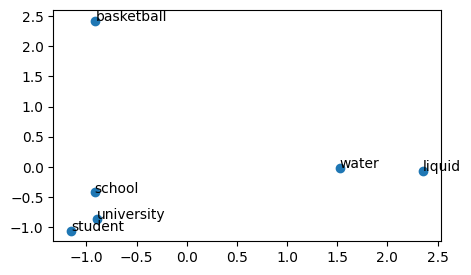

In [15]:
plt.figure(figsize=(5,3))
plt.scatter(result[:,0], result[:,1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

##Applying word2vec on the Dataset

In [16]:
df = pd.read_csv('/content/drive/MyDrive/365Project/cleanedISOT.csv')
df.dropna(subset=['clean_text'], inplace=True)

In [17]:
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

In [18]:
df.head()

,class,clean_text,tokens
0,0,donald trump send embarrass new year eve messa...,"[donald, trump, send, embarrass, new, year, ev..."
1,0,drunk brag trump staffer start russian collus ...,"[drunk, brag, trump, staffer, start, russian, ..."
2,0,sheriff david clark becom internet joke threat...,"[sheriff, david, clark, becom, internet, joke,..."
3,0,trump obsess even obama name code websit imag ...,"[trump, obsess, even, obama, name, code, websi..."
4,0,pope franci call donald trump christma speech ...,"[pope, franci, call, donald, trump, christma, ..."


In [19]:
from scipy.sparse import csr_matrix

#sent_to_avg_vec: Takes the vectors for all the words in each sentence and combines it all in one vector by taking the average of the values
def sent_to_avg_vec(sent, wv, dim):
    valid_embeddings = [wv[word] for word in sent if word in wv]

    if valid_embeddings:
        avg_embedding = np.mean(valid_embeddings, axis=0)
    else:
        avg_embedding = np.zeros(dim)

    return avg_embedding

dim = wv.vector_size
sent = ["example", "sentence", "tokens"]
avg_vector = sent_to_avg_vec(sent, wv, dim)


In [20]:
df['avg_vector'] = df['tokens'].apply(lambda x: sent_to_avg_vec(x, wv, wv.vector_size))

In [21]:
vectors_df = pd.DataFrame(df['avg_vector'].tolist())

In [22]:
result_df = pd.concat([df, vectors_df], axis=1)

In [23]:
result_df = result_df.drop(['avg_vector'], axis=1)

In [24]:
result_df.head()

,class,clean_text,tokens,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,0.0,donald trump send embarrass new year eve messa...,"[donald, trump, send, embarrass, new, year, ev...",0.008690,0.052507,0.028267,0.102293,-0.074369,0.009419,0.028947,...,0.059832,0.068490,-0.080953,-0.004112,-0.045639,-0.103846,-0.008104,-0.058081,-0.004457,0.018617
1,0.0,drunk brag trump staffer start russian collus ...,"[drunk, brag, trump, staffer, start, russian, ...",-0.027989,0.026530,0.016263,0.086592,-0.066898,0.005858,0.021110,...,0.041051,0.045733,-0.038417,0.032777,-0.042354,-0.068702,-0.014460,-0.076555,0.002295,0.029151
2,0.0,sheriff david clark becom internet joke threat...,"[sheriff, david, clark, becom, internet, joke,...",0.003965,0.022524,0.009441,0.068881,-0.057199,0.015096,0.012128,...,0.031391,0.053071,-0.072740,0.052704,-0.060610,-0.105792,-0.011891,-0.083825,-0.018013,0.038989
3,0.0,trump obsess even obama name code websit imag ...,"[trump, obsess, even, obama, name, code, websi...",0.004360,0.013982,0.036881,0.103634,-0.078380,-0.006526,0.041167,...,0.056276,0.049329,-0.034890,0.030771,-0.008382,-0.081602,0.005466,-0.107022,-0.028669,0.006137
4,0.0,pope franci call donald trump christma speech ...,"[pope, franci, call, donald, trump, christma, ...",0.026814,0.045902,0.031234,0.106746,-0.069552,0.001861,0.060818,...,-0.015138,0.040970,-0.092981,-0.012650,-0.034230,-0.018661,-0.033963,-0.042701,0.041217,0.024768


In [25]:
len(result_df)

44878

In [26]:
columns_to_check = list(range(0, 300)) + ['class']

In [27]:
df = result_df.dropna(subset=columns_to_check)

In [28]:
len(df)

44860

##PCA

In [29]:
df.columns = [str(col) for col in df.columns]
df.columns = map(str, df.columns)
df.head()

,class,clean_text,tokens,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,0.0,donald trump send embarrass new year eve messa...,"[donald, trump, send, embarrass, new, year, ev...",0.008690,0.052507,0.028267,0.102293,-0.074369,0.009419,0.028947,...,0.059832,0.068490,-0.080953,-0.004112,-0.045639,-0.103846,-0.008104,-0.058081,-0.004457,0.018617
1,0.0,drunk brag trump staffer start russian collus ...,"[drunk, brag, trump, staffer, start, russian, ...",-0.027989,0.026530,0.016263,0.086592,-0.066898,0.005858,0.021110,...,0.041051,0.045733,-0.038417,0.032777,-0.042354,-0.068702,-0.014460,-0.076555,0.002295,0.029151
2,0.0,sheriff david clark becom internet joke threat...,"[sheriff, david, clark, becom, internet, joke,...",0.003965,0.022524,0.009441,0.068881,-0.057199,0.015096,0.012128,...,0.031391,0.053071,-0.072740,0.052704,-0.060610,-0.105792,-0.011891,-0.083825,-0.018013,0.038989
3,0.0,trump obsess even obama name code websit imag ...,"[trump, obsess, even, obama, name, code, websi...",0.004360,0.013982,0.036881,0.103634,-0.078380,-0.006526,0.041167,...,0.056276,0.049329,-0.034890,0.030771,-0.008382,-0.081602,0.005466,-0.107022,-0.028669,0.006137
4,0.0,pope franci call donald trump christma speech ...,"[pope, franci, call, donald, trump, christma, ...",0.026814,0.045902,0.031234,0.106746,-0.069552,0.001861,0.060818,...,-0.015138,0.040970,-0.092981,-0.012650,-0.034230,-0.018661,-0.033963,-0.042701,0.041217,0.024768


In [30]:
df_numeric = df.select_dtypes(include=[np.number])

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

df_pca = pca.fit_transform(df_scaled)


In [33]:
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

In [34]:
df_pca.head()

,PC1,PC2
0,7.113584,-3.129249
1,2.468438,2.519048
2,8.342286,2.582270
3,6.576223,-1.924283
4,0.229864,-4.109456


###Logistic Regression For PCA

In [35]:
from sklearn.model_selection import train_test_split

Y = df['class']

X_train, X_test, Y_train, Y_test = train_test_split(df_pca, Y, test_size=0.2, random_state=42)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()

model.fit(X_train, Y_train)

LogisticRegression()

In [37]:
from sklearn import metrics
predicted = model.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(Y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(Y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(Y_test, predicted))

Logistic Regression Accuracy: 0.8437360677663843
Logistic Regression Precision: 0.8328323699421966
Logistic Regression Recall: 0.8413921980845597


## Logistic Regression WITHOUT PCA

In [38]:
X = df[[str(i) for i in range(300)]]
Y = df['class']

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [40]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

In [41]:
classifier.fit(X_train,Y_train)

LogisticRegression()

In [42]:
df.shape

(44860, 303)

In [43]:
from sklearn import metrics
predicted = classifier.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(Y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(Y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(Y_test, predicted))

Logistic Regression Accuracy: 0.9400356665180561
Logistic Regression Precision: 0.9343235089347877
Logistic Regression Recall: 0.9404344779257183
